In [1]:
import torch
from torch import nn
from d2l import torch as d2l

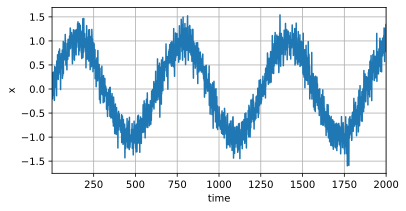

In [54]:
T=2000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# x1 = torch.sin(0.01 * time) + torch.normal(0, 0.1, (T,))
d2l.plot(time, [x], xlabel='time', ylabel='x', xlim=[1, 2000], figsize=(6, 3))

In [68]:
tau = 4
features = torch.zeros((T - tau, tau))#features->(996,4)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 1000
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


In [ ]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def estimate_flops(model, input_size):
    """
    Estimates the number of FLOPS for the given model and input size.
    This is a simplified version and does not account for all operations.
    """
    total_flops = 0
    for module in model.modules():
        if isinstance(module, nn.Linear):
            # For a linear layer, the number of FLOPS is:
            # (input_size * output_size + output_size) * number_of_inputs
            # We multiply by 2 because each element-wise multiplication contributes 2 FLOPS (1 for multiply, 1 for add)
            total_flops += 2 * (module.weight.nelement() * module.out_features + module.out_features)
    return total_flops

In [36]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


In [69]:
####训练模型
net = get_net()
train(net, train_iter, loss, 20, 0.02)

epoch 1, loss: 0.056401
epoch 2, loss: 0.056231
epoch 3, loss: 0.052021
epoch 4, loss: 0.053539
epoch 5, loss: 0.053956
epoch 6, loss: 0.054907
epoch 7, loss: 0.055857
epoch 8, loss: 0.057402
epoch 9, loss: 0.055626
epoch 10, loss: 0.054537
epoch 11, loss: 0.051310
epoch 12, loss: 0.053687
epoch 13, loss: 0.055167
epoch 14, loss: 0.056875
epoch 15, loss: 0.054977
epoch 16, loss: 0.056223
epoch 17, loss: 0.052170
epoch 18, loss: 0.057440
epoch 19, loss: 0.051878
epoch 20, loss: 0.054733


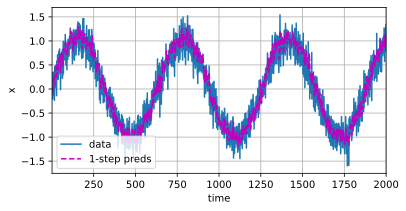

In [70]:
####预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 2000],
         figsize=(6, 3))

In [72]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i]=net(
        multistep_preds[i-tau:i].reshape((1,-1)))
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 2000], figsize=(6, 3))

KeyboardInterrupt: 